In [1]:
%matplotlib inline
import datetime
import numpy as np
import pathlib as pl
import pandas as pd
import geopandas as gpd
import sys
import xugrid

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as dates
import matplotlib.ticker as ticker

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import flopy
import flopy.plot.styles as styles

In [2]:
sys.path.append("../common")
from liss_settings import (
                            cx, cx_provider, 
                            extent, boxx, boxy, 
                            mf6_model_crs, 
                            set_title_string,  
                            fig_ext, transparent, 
                            get_modflow_coupling_tag, 
                            get_dflow_dtuser, 
                            get_dflow_grid_name,
                          )

In [3]:
figsize = (10.6, 5.95)
alpha = 0.5
basemap_kwds = {"attribution": False, "source": cx_provider, "zoom": 13}
progress_kwds = {"lw": 0.0, "fc": "cyan", "alpha": 0.25, "zorder": 10}
animation_ws = pl.Path("animations")
animation_ws.mkdir(exist_ok=True, parents=True)

#### Set unit conversion factors

In [4]:
d2sec = 24. * 60. * 60.
hrs2sec = 60. * 60. 
m2ft = 3.28081
cfd2cms = 1.0 / ((3.28082**3) * 86400.)

In [5]:
units = "mm"
conversion_factor = 1.0
if units == "mm":
    conversion_factor = 1000.0 / 3.28081
elif units == "in":
    conversion_factor = 12.0
head_units = "m"
head_conversion_factor = 1.0
if head_units == "m":
    head_conversion_factor = 1.0 / 3.28081
stage_units = head_units
stage_conversion_factor = 1.0
if stage_units == "ft":
    stage_conversion_factor = 3.28081
flux_units = units
if flux_units == "mm":
    flux_conversion_factor = 1000.0
elif flux_units == "in":
    flux_conversion_factor = 3.28081 * 12.


#### Set the MODFLOW coupling frequency

Change the `mf_couple_freq_hours` value. Only tested for multiple of the D-Flow FM DtUser variable. Will not work for `mf_couple_freq_hours` values greater than 24.

In [6]:
control_path = pl.Path("../dflow-fm/coarse/tides_2018/base/FlowFM.mdu") # change this if using a different D-Flow FM control file
grid_name = get_dflow_grid_name(control_path)
print(grid_name)

LIS_GPT_PJ_cells3_net


In [7]:
coastal_dtuser = get_dflow_dtuser(control_path)
print(coastal_dtuser)

300.0


In [10]:
mf_couple_freq_hours = 8.0  #Change this value to change the coupling frequency
mf_couple_freq = mf_couple_freq_hours * hrs2sec
coastal_per_mf = int(mf_couple_freq / coastal_dtuser)
mf_output_sample = int(24. / mf_couple_freq_hours)

print(
    f"MODFLOW coupling frequency {mf_couple_freq_hours} hours\n" +
    f"MODFLOW coupled to the coastal every {coastal_per_mf} output time step ({coastal_dtuser} sec.)\n" +
    f"MODFLOW output sampling frequency {mf_output_sample}"
) 

mf_tag = get_modflow_coupling_tag(mf_couple_freq_hours)
print(f"MODFLOW coupling tag: {mf_tag}")

MODFLOW coupling frequency 8.0 hours
MODFLOW coupled to the coastal every 96 output time step (300.0 sec.)
MODFLOW output sampling frequency 3
MODFLOW coupling tag: 08.00H


# Coastal model results (used for the calendar times)

In [11]:
full_results_ds = xugrid.open_dataset("../dflow-fm/coarse/tides_2018/run/output/FlowFM_map.nc")
full_results_ds

<xarray.Dataset> Size: 785MB
Dimensions:                      (mesh2d_nNodes: 13365, mesh2d_nEdges: 35029,
                                  mesh2d_nFaces: 21660,
                                  mesh2d_nMax_face_nodes: 4, time: 241)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 107kB ...
    mesh2d_node_y                (mesh2d_nNodes) float64 107kB ...
    mesh2d_edge_x                (mesh2d_nEdges) float64 280kB ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 280kB ...
    mesh2d_face_x                (mesh2d_nFaces) float64 173kB ...
    mesh2d_face_y                (mesh2d_nFaces) float64 173kB ...
  * time                         (time) datetime64[ns] 2kB 2018-09-20 ... 201...
  * mesh2d_nNodes                (mesh2d_nNodes) int64 107kB 0 1 ... 13363 13364
  * mesh2d_nFaces                (mesh2d_nFaces) int64 173kB 0 1 ... 21658 21659
  * mesh2d_nEdges                (mesh2d_nEdges) int64 280kB 0 1 ... 35027 35028
Dimensions without coordinates: mesh2d_nMax_face_nodes
Data variables: (12/23)
    projected_coordinate_system  int32 4B ...
    mesh2d_node_z                (mesh2d_nNodes) float64 107kB ...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 693kB ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 693kB ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 280kB ...
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 173kB ...
    ...                           ...
    mesh2d_q1                    (time, mesh2d_nEdges) float64 68MB ...
    mesh2d_viu                   (time, mesh2d_nEdges) float64 68MB ...
    mesh2d_diu                   (time, mesh2d_nEdges) float64 68MB ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 42MB ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 42MB ...
    mesh2d_czu                   (time, mesh2d_nEdges) float64 68MB ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         D-Flow FM 1.2.123.69078M. Model:
    history:        Created on 2025-08-15T15:00:55-0400, D-Flow FM
    date_created:   2025-08-15T15:00:55-0400
    date_modified:  2025-08-15T15:00:55-0400
    Conventions:    CF-1.8 UGRID-1.0 Deltares-0.10

## Extract subset of coastal model for plotting 

In [12]:
results_ds = full_results_ds

In [13]:
coastal_gdf = results_ds["mesh2d_nFaces"].ugrid.to_geodataframe(name="cell")
coastal_gdf["stage"] = np.zeros((results_ds["mesh2d_nFaces"].values.shape[0]), dtype=float)
coastal_gdf.set_crs(32618, inplace=True)

,cell,mesh2d_face_x,mesh2d_face_y,geometry,stage
mesh2d_nFaces,,,,,
0,0,581304.782862,4.530140e+06,"POLYGON ((581278.095 4530797.658, 580803.668 4...",0.0
1,1,580948.525069,4.529244e+06,"POLYGON ((580509.155 4529024.860, 581120.782 4...",0.0
2,2,581165.501727,4.529318e+06,"POLYGON ((581637.189 4529571.190, 580803.668 4...",0.0
3,3,580708.393782,4.528634e+06,"POLYGON ((580509.155 4529024.860, 580305.524 4...",0.0
4,4,581718.153967,4.528955e+06,"POLYGON ((581930.574 4528371.125, 581637.189 4...",0.0
...,...,...,...,...,...
21655,21655,698004.338382,4.540132e+06,"POLYGON ((697883.097 4539946.737, 698216.083 4...",0.0
21656,21656,698641.288943,4.539406e+06,"POLYGON ((698946.834 4539209.344, 698783.296 4...",0.0
21657,21657,697760.020796,4.539259e+06,"POLYGON ((698001.058 4539041.376, 697939.776 4...",0.0


In [14]:
cell_areas = coastal_gdf.area.values
cell_areas

array([485787.0769455 , 245736.94240417, 364548.67635787, ...,
       201829.91088719, 173555.20728132, 217665.80500212])

In [15]:
time_str = results_ds["time"].values
time_str, time_str[-1]

(array(['2018-09-20T00:00:00.000000000', '2018-09-20T01:00:00.000000000',
        '2018-09-20T02:00:00.000000000', '2018-09-20T03:00:00.000000000',
        '2018-09-20T04:00:00.000000000', '2018-09-20T05:00:00.000000000',
        '2018-09-20T06:00:00.000000000', '2018-09-20T07:00:00.000000000',
        '2018-09-20T08:00:00.000000000', '2018-09-20T09:00:00.000000000',
        '2018-09-20T10:00:00.000000000', '2018-09-20T11:00:00.000000000',
        '2018-09-20T12:00:00.000000000', '2018-09-20T13:00:00.000000000',
        '2018-09-20T14:00:00.000000000', '2018-09-20T15:00:00.000000000',
        '2018-09-20T16:00:00.000000000', '2018-09-20T17:00:00.000000000',
        '2018-09-20T18:00:00.000000000', '2018-09-20T19:00:00.000000000',
        '2018-09-20T20:00:00.000000000', '2018-09-20T21:00:00.000000000',
        '2018-09-20T22:00:00.000000000', '2018-09-20T23:00:00.000000000',
        '2018-09-21T00:00:00.000000000', '2018-09-21T01:00:00.000000000',
        '2018-09-21T02:00:00.000000000

In [16]:
output_freq = int(np.timedelta64(1, "D") / (time_str[1] - time_str[0]))
time_index = np.arange(0, time_str.shape[0], output_freq)
time_index.shape, time_index[1:]

((11,), array([ 24,  48,  72,  96, 120, 144, 168, 192, 216, 240]))

In [17]:
time_mf = time_str[time_index]
print(time_mf.shape, time_mf)

(11,) ['2018-09-20T00:00:00.000000000' '2018-09-21T00:00:00.000000000'
 '2018-09-22T00:00:00.000000000' '2018-09-23T00:00:00.000000000'
 '2018-09-24T00:00:00.000000000' '2018-09-25T00:00:00.000000000'
 '2018-09-26T00:00:00.000000000' '2018-09-27T00:00:00.000000000'
 '2018-09-28T00:00:00.000000000' '2018-09-29T00:00:00.000000000'
 '2018-09-30T00:00:00.000000000']


# Load the MODFLOW model

In [18]:
mf_run_path = pl.Path(f"../modflow/pj_2018_adjust_CHDA1/run_{mf_tag}/")
mf_npz_path = mf_run_path

In [19]:
sim = flopy.mf6.MFSimulation.load(sim_ws=mf_run_path)
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ghb...
    loading package drn...
    loading package chd...
    loading package wel...
    loading package chd...
    loading package rch...
    loading package sto...
    loading package npf...
    loading package ic...
    loading package oc...
    loading package buy...
  loading model gwt6...
    loading package dis...
    loading package fmi...
    loading package ssm...
    loading package mst...
    loading package adv...
    loading package ic...
    loading package oc...
  loading exchange package gwf-gwt_exg_0...
  loading solution package gwf...
  loading solution package gwt...


In [ ]:
mg = gwf.modelgrid # import model grid
mg.set_coord_info(crs='epsg:4456')
mg_gdf = mg.geo_dataframe
print(mg_gdf.crs)



EPSG:4456


In [ ]:
tdis = sim.tdis
mf_startdate = tdis.start_date_time.array

mf_perioddata= tdis.perioddata.array
mf_SPdates = [pd.to_datetime(mf_startdate)]

for perlen, nstp, tsmult in mf_perioddata:
    mf_SPdates.append(mf_SPdates[-1] + pd.Timedelta(days = perlen))
# remove the last date because it is extra
mf_SPdates = mf_SPdates[:-1]
# Compute cumulative total times at the end of each stress period
mf_totaltimes= tdis.perioddata.array['perlen'].cumsum()

mf_tdis_df = pd.DataFrame({'Date':mf_SPdates,
                           'SP': list(mf_perioddata),
                           'totim': mf_totaltimes})
mf_tdis_df

,Date,SP,totim
0,2017-01-01,"[365.0, 3, 1.3]",365.0
1,2018-01-01,"[1.0, 3, 1.0]",366.0
2,2018-01-02,"[1.0, 3, 1.0]",367.0
3,2018-01-03,"[1.0, 3, 1.0]",368.0
4,2018-01-04,"[1.0, 3, 1.0]",369.0
...,...,...,...
361,2018-12-27,"[1.0, 3, 1.0]",726.0
362,2018-12-28,"[1.0, 3, 1.0]",727.0
363,2018-12-29,"[1.0, 3, 1.0]",728.0
364,2018-12-30,"[1.0, 3, 1.0]",729.0


In [ ]:
hobj = gwf.output.head()

totimes = hobj.get_times()
print(f"{len(totimes)}\n{totimes}")

273
[365.0, 366.0, 367.0, 368.0, 369.0, 370.0, 371.0, 372.0, 373.0, 374.0, 375.0, 376.0, 377.0, 378.0, 379.0, 380.0, 381.0, 382.0, 383.0, 384.0, 385.0, 386.0, 387.0, 388.0, 389.0, 390.0, 391.0, 392.0, 393.0, 394.0, 395.0, 396.0, 397.0, 398.0, 399.0, 400.0, 401.0, 402.0, 403.0, 404.0, 405.0, 406.0, 407.0, 408.0, 409.0, 410.0, 411.0, 412.0, 413.0, 414.0, 415.0, 416.0, 417.0, 418.0, 419.0, 420.0, 421.0, 422.0, 423.0, 424.0, 425.0, 426.0, 427.0, 428.0, 429.0, 430.0, 431.0, 432.0, 433.0, 434.0, 435.0, 436.0, 437.0, 438.0, 439.0, 440.0, 441.0, 442.0, 443.0, 444.0, 445.0, 446.0, 447.0, 448.0, 449.0, 450.0, 451.0, 452.0, 453.0, 454.0, 455.0, 456.0, 457.0, 458.0, 459.0, 460.0, 461.0, 462.0, 463.0, 464.0, 465.0, 466.0, 467.0, 468.0, 469.0, 470.0, 471.0, 472.0, 473.0, 474.0, 475.0, 476.0, 477.0, 478.0, 479.0, 480.0, 481.0, 482.0, 483.0, 484.0, 485.0, 486.0, 487.0, 488.0, 489.0, 490.0, 491.0, 492.0, 493.0, 494.0, 495.0, 496.0, 497.0, 498.0, 499.0, 500.0, 501.0, 502.0, 503.0, 504.0, 505.0, 506.0, 5

In [ ]:
bobj = gwf.output.budget()

bobj.get_unique_record_names()

[b'          STO-SS',
 b'          STO-SY',
 b'    FLOW-JA-FACE',
 b'             WEL',
 b'             DRN',
 b'             GHB',
 b'            RCHA',
 b'             CHD']

## Calculate the mean recharge

In [ ]:
mean_recharge = []
for totim in totimes:
    rQ = bobj.get_data(text="RCH", totim=totim)[0]
    q = rQ["q"]
    idx = q > 0.
    mean_recharge.append(q[idx].mean())
    
mean_recharge = np.array(mean_recharge) * (conversion_factor / (500. * 500.))

In [ ]:
mean_recharge.shape, mean_recharge.max()

((273,), 12.899978041224433)

In [ ]:
df = pd.DataFrame(data=mean_recharge)
df.index = pd.to_datetime(mf_SPdates[:len(df)])
df

,0
2017-01-01,0.541672
2018-01-01,0.143221
2018-01-02,0.143221
2018-01-03,0.143221
2018-01-04,0.143221
...,...
2018-09-25,12.899978
2018-09-26,5.965826
2018-09-27,6.216040
2018-09-28,3.050404


## Load ghb shapefile

In [ ]:
print(mg_gdf.crs)

EPSG:4456


In [ ]:
ghb_gdf = gpd.read_file("../modflow/gis/PJ/PJ_ghb_4456.shp")
ghb_gdf["head_difference"] = np.zeros((ghb_gdf.shape[0]), dtype=float)
ghb_gdf.set_crs(crs='epsg:4456', inplace=True)
ghb_gdf.crs

<Projected CRS: EPSG:4456>
Name: NAD27 / New York Long Island
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: New York CS27 Long Island zone
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1927
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

#### Load ghb data calculated using coastal model results

In [ ]:
ghb_elev = np.load(f"{mf_npz_path}/ghb_elev.npz")
ghb_elev

NpzFile '..\\modflow\\pj_2018_adjust_CHDA1\\run_08.00H/ghb_elev.npz' with keys: 0, 1, 2, 3, 4...

In [ ]:
ghb_cond = np.load(f"{mf_npz_path}/ghb_cond.npz")
ghb_cond

NpzFile '..\\modflow\\pj_2018_adjust_CHDA1\\run_08.00H/ghb_cond.npz' with keys: 0, 1, 2, 3, 4...

In [ ]:
qext_elev = np.load(f"{mf_npz_path}/qext.npz")
qext_elev

NpzFile '..\\modflow\\pj_2018_adjust_CHDA1\\run_08.00H/qext.npz' with keys: 0, 1, 2, 3, 4...

In [ ]:
qsize, qmin, qmax = 0, 1e30, -1e30
for key, value in qext_elev.items():
    qsize = value.shape[0]
    qmin = min(qmin, np.nanmin(value))
    qmax = max(qmax, np.nanmax(value))
qmin *= 3.28081 * 12.0
qmax *= 3.28081 * 12.0
qsize, qmin, qmax

(21660, -9.046260718589432, 12.385460288188915)

In [ ]:
qmin, qmax = -8.0, 8.0

In [ ]:
qvalue = np.full(qsize, np.nan, dtype=float)

In [ ]:
time_keys = ghb_elev.files
sampled_time_keys = time_keys[mf_output_sample-1::mf_output_sample]
print(
    len(time_keys),
    len(sampled_time_keys), 
    sampled_time_keys
)

30 10 ['2', '5', '8', '11', '14', '17', '20', '23', '26', '29']


In [ ]:
v = hobj.get_data(totim=366)[0]
v[v == 1.e30] = 0.
v.min(), v.max(), v.mean()

(0.0, 55.81281960732763, 17.573489496055274)

(263141.6833299593, 273603.30500920594)

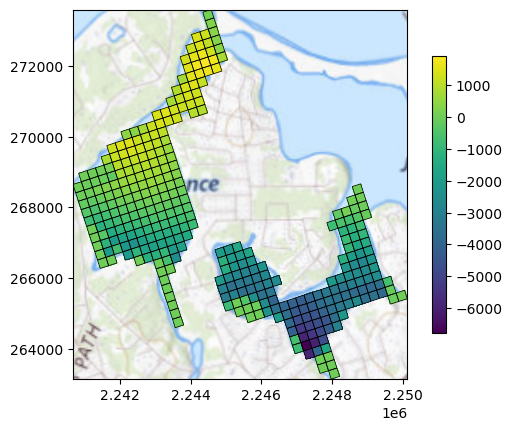

In [ ]:
date = pd.Timestamp("2018-09-20")
#get the totim for that date
idx = mf_tdis_df.loc[mf_tdis_df['Date'] == date, 'totim'].iloc[0]


fig, ax = plt.subplots()
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
# get the GHB array for that timestep
ghb_array = bobj.get_data(text="GHB", totim=idx, full3D=True)[0]
# plot the GHB array
hc = mm.plot_array(ghb_array)
# overlay your GHB polygons
ghb_gdf.plot(ax=mm.ax, lw=0.5, ec="black", color="none")
# add colorbar
plt.colorbar(hc, ax=mm.ax, shrink=0.75)
# add basemap
cx.add_basemap(mm.ax, crs=mg_gdf.crs, **basemap_kwds)
# zoom to ghb_gdf bounds
xmin, ymin, xmax, ymax = ghb_gdf.total_bounds
mm.ax.set_xlim(xmin, xmax)
mm.ax.set_ylim(ymin, ymax)

# optional: set title
# mm.ax.set_title(f"GHB flux at {title_str}", size=8)


## Load CHD shapefile

In [ ]:
chd_gdf = gpd.read_file("../modflow/gis/PJ/PJ_chd_4456.shp")
chd_gdf["head_difference"] = np.zeros((chd_gdf.shape[0]), dtype=float)
chd_gdf.set_crs(mg.crs, inplace=True)
chd_gdf.crs

<Projected CRS: EPSG:4456>
Name: NAD27 / New York Long Island
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: New York CS27 Long Island zone
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1927
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [ ]:
chd_elev = np.load(f"{mf_npz_path}/chd_elev.npz")
chd_elev

NpzFile '..\\modflow\\pj_2018_adjust_CHDA1\\run_08.00H/chd_elev.npz' with keys: 0, 1, 2, 3, 4...

(263949.47038144234, 277247.02119390655)

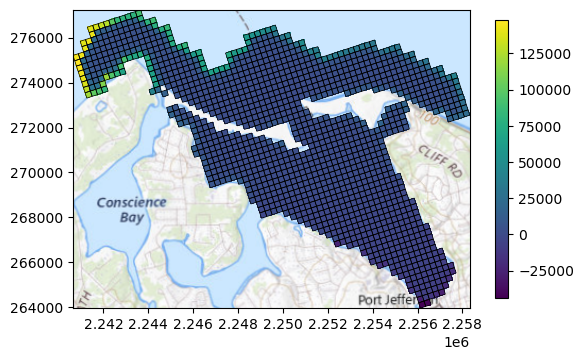

In [ ]:
date = pd.Timestamp("2018-09-20")
#get the totim for that date
idx = mf_tdis_df.loc[mf_tdis_df['Date'] == date, 'totim'].iloc[0]


fig, ax = plt.subplots()
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
# get the GHB array for that timestep
chd_array = bobj.get_data(text="CHD", totim=idx, full3D=True)[0]
# plot the GHB array
hc = mm.plot_array(chd_array)
# overlay your GHB polygons
chd_gdf.plot(ax=mm.ax, lw=0.5, ec="black", color="none")
# add colorbar
plt.colorbar(hc, ax=mm.ax, shrink=0.75)
# add basemap
cx.add_basemap(mm.ax, crs=mg_gdf.crs, **basemap_kwds)
# zoom to ghb_gdf bounds
xmin, ymin, xmax, ymax = chd_gdf.total_bounds
mm.ax.set_xlim(xmin, xmax)
mm.ax.set_ylim(ymin, ymax)

# optional: set title
# mm.ax.set_title(f"GHB flux at {title_str}", size=8)


In [ ]:
mosaic_list = [
    ["c","c","c","c"],
    ["a","a","b","b"],
    ["a","a","b","b"],
    ["a","a","b","b"],
    ["a","a","b","b"],
    ]

In [ ]:
if units == "in":
    head_levels = [1, 2, 3]
    head_min, head_max = -1, 5
    stage_min, stage_max = -3, 3
    rch_min, rch_max = 0, 3
    flux_min, flux_max = -1, 1
elif units == "mm":
    head_levels = [0.25, 0.5, 0.75, 1.0]
    head_min, head_max = -0.25, 2
    stage_min, stage_max = -1, 1
    rch_min, rch_max = 0, 100
    flux_min, flux_max = -25, 25


## MODFLOW 6 results

In [ ]:
sampled_time_keys

['2', '5', '8', '11', '14', '17', '20', '23', '26', '29']

NameError: name 'mf6_gpd' is not defined

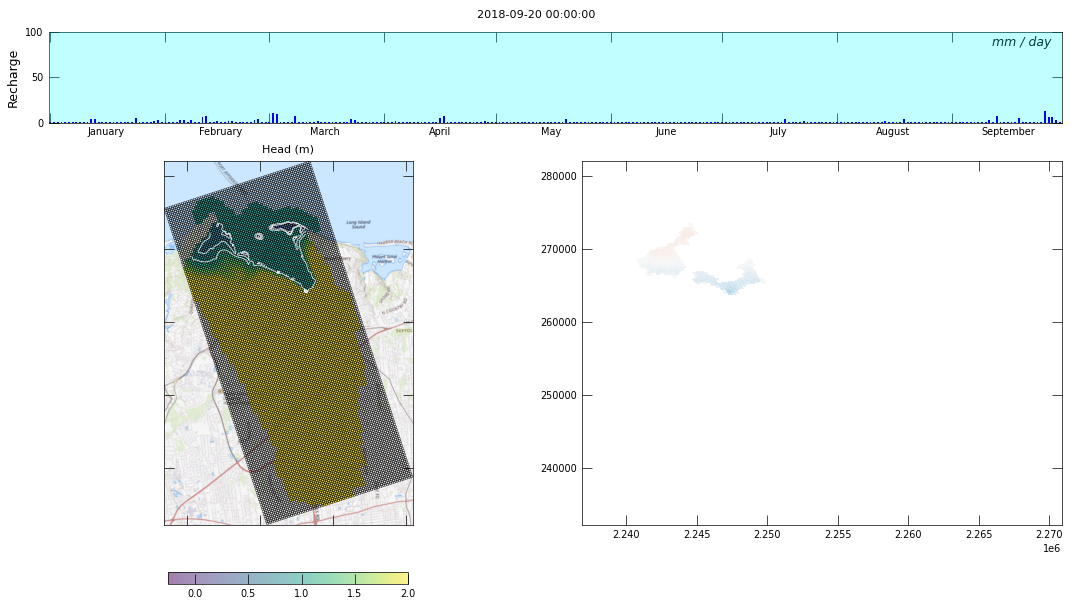

In [ ]:
date = pd.Timestamp("2018-09-20")
#get the totim for that date
totim = mf_tdis_df.loc[mf_tdis_df['Date'] == date, 'totim'].iloc[0]
with styles.USGSMap():
    fig, axd = plt.subplot_mosaic(
    mosaic_list,
    layout="constrained", 
    figsize=figsize,
    )    

    ax = axd["c"]
    ax.set_xlim(-0.5,mean_recharge.shape[0]-.5)
    ax.set_ylim(rch_min, rch_max)

    df.plot(kind="bar", ax=ax, legend=False, zorder=111, color="blue")
    fb = ax.fill_between([-0.5, totim+0.5], rch_max, **progress_kwds)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%B'))
    
    # Remove the tick lines
    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment('center')

    ax.set_ylabel("Recharge")
    styles.add_text(ax, text=f"{units} / day", x=0.99, y=0.95, bold=False, va="top", ha="right")
    
    title_str = set_title_string(date)  
    fig.suptitle(title_str, fontsize=8)

    h = hobj.get_data(totim=totim)
    h[h < 1e29] *= head_conversion_factor
    q = bobj.get_data(text="GHB", totim=totim, full3D=True)[0]
    q[q == 0.0] = np.nan   
    q *= conversion_factor / (500. * 500.)
    
    ax = axd["a"]
    mm0 = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    hc = mm0.plot_array(h, alpha=alpha, vmin=head_min, vmax=head_max)
    mg_gdf.plot(ax=ax, lw=0.25, ec="black", color="none")
    ca = mm0.contour_array(h, levels=head_levels, colors="white", linewidths=0.5)
    plt.colorbar(hc, ax=ax, shrink=0.5, orientation="horizontal")
    cx.add_basemap(ax, crs=mg_gdf.crs, **basemap_kwds)
    
    ax.set_title(f"Head ({head_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    

    ax = axd["b"]
    mm1 = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    ghbq = mm1.plot_array(-q, alpha=alpha, cmap="RdBu", vmin=flux_min , vmax=flux_max)
    mf6_gpd.plot(ax=ax, lw=0.25, ec="black", color="none")
    plt.colorbar(ghbq, ax=ax, shrink=0.5, extend="both", orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Coastal discharge ({units}/day)", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # coastal model inset
    ax_ins = axd["b"].inset_axes(
        [-0.125, 0.55, 0.45, 0.45],
        xticklabels=[], 
        yticklabels=[],
    )
    wdp = full_results_ds["mesh2d_s1"].isel(time=time_index[totim]).ugrid.plot(animated=True, ax=ax_ins, cmap="RdBu", vmin=flux_min, vmax=flux_max, lw=0.0, alpha=alpha, add_colorbar=False)
    gdfp = coastal_gdf.plot(color="black", fc="none", lw=0.25, ax=ax_ins)

    qvalue = qext_elev[str(npz_idx)]
    qvalue *= flux_conversion_factor * 86400. / cell_areas
    qvalue[qvalue == 0.0] = np.nan
    wdp.set_array(qvalue)

    ax_ins.set_xlim(extent[:2])
    ax_ins.set_ylim(extent[2:])
    cx.add_basemap(ax_ins, crs=gp_gpd.crs, attribution=False, source=cx_provider, zoom=11)

    ax_ins.set_title(f"Coastal Exchange ({flux_units})", size=8)
    ax_ins.set_xlabel(None)
    ax_ins.set_ylabel(None)
    ax_ins.set_xticklabels([])
    ax_ins.set_yticklabels([])      

    fig.align_labels() 

    fig.savefig(f"figures/greenport_modflow_dflow_results{fig_ext}", dpi=300, transparent=transparent)

#### Animate MODFLOW Results

In [ ]:
hr_sample = 24
days_per_sec = 2
fps = int(days_per_sec * 24 / hr_sample)
fps

In [ ]:
time_index[1:].shape[0], len(totimes)

In [ ]:
frame1 = min(len(totimes), time_index[1:].shape[0])
frames = np.arange(0, frame1, 1)[1:]
frame1, frames.shape

In [ ]:
ani_ext = ".mp4"
Writer = mpl.animation.writers["ffmpeg"]
writer = Writer(fps=fps, metadata=dict(artist="jdhughes"), bitrate=2056)

In [ ]:
with styles.USGSMap():
    fig, axd = plt.subplot_mosaic(
    mosaic_list,
    layout="constrained", 
    figsize=figsize,
    )    

    ax = axd["c"]
    ax.set_xlim(-0.5, mean_recharge.shape[0]-.5)
    ax.set_ylim(0, rch_max)

    df.plot(kind="bar", ax=ax, legend=False, zorder=111, color="blue")
    fb = ax.fill_between([-0.5, -0.5], rch_max, **progress_kwds)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%B'))
    
    # Remove the tick lines
    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment('center')

    ax.set_ylabel("Recharge")
    styles.add_text(ax, text=f"{units} / day", x=0.99, y=0.95, bold=False, va="top", ha="right")    
    
    title_str = set_title_string(time_mf[0]) 
    fig.suptitle(title_str, fontsize=8)

    h = hobj.get_data(totim=totim)
    h[h < 1e29] *= head_conversion_factor
    q = bobj.get_data(text="GHB", totim=totim, full3D=True)[0]
    q[q == 0.0] = np.nan
    q *= conversion_factor / (500. * 500.)
    
    ax = axd["a"]
    
    mm0 = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    hc = mm0.plot_array(h, alpha=alpha, vmin=head_min, vmax=head_max)
    mf6_grid_gpd.plot(ax=ax, lw=0.25, ec="black", color="none")
    C = mm0.contour_array(h, levels=head_levels, colors="white", linewidths=0.5)
    plt.colorbar(hc, ax=ax, shrink=0.5, orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Head ({head_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax = axd["b"]
    mm1 = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    ghbq = mm1.plot_array(-q, alpha=alpha, cmap="RdBu", vmin=flux_min, vmax=flux_max)
    mf6_gpd.plot(ax=ax, lw=0.25, ec="black", color="none")
    plt.colorbar(ghbq, ax=ax, shrink=0.5, extend="both", orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)

    ax.set_title(f"Coastal discharge ({units}/day)", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # coastal model inset
    ax_ins = axd["b"].inset_axes(
        [-0.125, 0.55, 0.45, 0.45],
        xticklabels=[], 
        yticklabels=[],
    )
    wdp = full_results_ds["mesh2d_s1"].isel(time=time_index[totim]).ugrid.plot(animated=True, ax=ax_ins, cmap="RdBu", vmin=flux_min, vmax=flux_max, lw=0.0, alpha=alpha, add_colorbar=False)
    gdfp = coastal_gdf.plot(color="black", fc="none", lw=0.25, ax=ax_ins)
    wdp.set_array(qvalue)

    ax_ins.set_xlim(extent[:2])
    ax_ins.set_ylim(extent[2:])
    cx.add_basemap(ax_ins, crs=gp_gpd.crs, attribution=False, source=cx_provider, zoom=11)

    ax_ins.set_title(f"Coastal Exchange ({units})", size=8)
    ax_ins.set_xlabel(None)
    ax_ins.set_ylabel(None)
    ax_ins.set_xticklabels([])
    ax_ins.set_yticklabels([])    
     

    fig.align_labels()    
    
    def func(idx):
        global C, fb

        ax = axd["c"]
        fb.remove()
        fb = ax.fill_between([-0.5, float(idx)+0.5], rch_max, **progress_kwds)
        
        on_time = set_title_string(time_mf[idx])
        fig.suptitle(on_time, fontsize=8)

        totim = totimes[idx]

        h = hobj.get_data(totim=totim)
        h[h < 1e29] *= head_conversion_factor
        q = bobj.get_data(text="GHB", totim=totim, full3D=True)[0]

        h[h == 1e30] = np.nan
        q[q == 0.0] = np.nan
        q *= conversion_factor / (500. * 500.)
        
        ax = axd["a"]
        hc.set_array(h[0])
        C.remove()
        C = mm0.contour_array(h, levels=head_levels, colors="white", linewidths=0.5)
        
        ax = axd["b"]
        ghbq.set_array(-q[0])

        qvalue = qext_elev[str(sampled_time_keys[idx])]
        qvalue *= flux_conversion_factor * 86400./ cell_areas
        qvalue[qvalue == 0.0] = np.nan
        # print(np.nanmin(qvalue), np.nanmax(qvalue))
        wdp.set_array(qvalue)
        
        return C, fb, wdp
    
    ani = FuncAnimation(fig, func, frames=frames, blit=False)
    
    plt.close()

ani.save(animation_ws / f"greenport_modflow_dflow_results{ani_ext}", writer=writer)
# HTML(ani.to_jshtml())

In [ ]:
head_idx = [(l, r, c) for l, r, c in zip(mf6_gpd["layer"], mf6_gpd["row"], mf6_gpd["column"])]
head_idx[:10]

In [ ]:
# specific to dflow
stage = results_ds["mesh2d_s1"]
depth = results_ds["mesh2d_waterdepth"]

In [ ]:
# specific to dflow
def mask_stage(idx):
    v = stage.isel(time=time_index[idx]).values
    d = depth.isel(time=time_index[idx]).values
    v[d < 0.001] = np.nan
    return v * stage_conversion_factor
    

In [ ]:
totim = 50
npz_idx = sampled_time_keys[totim]
with styles.USGSMap():
    fig, axd = plt.subplot_mosaic(
    mosaic_list,
    layout="constrained", 
    figsize=figsize,
    )    

    ax = axd["c"]
    ax.set_xlim(-0.5,mean_recharge.shape[0]-.5)
    ax.set_ylim(rch_min, rch_max)

    df.plot(kind="bar", ax=ax, legend=False, zorder=111, color="blue")
    fb = ax.fill_between([-0.5, totim+0.5], rch_max, **progress_kwds)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%B'))
    
    # Remove the tick lines
    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment('center')

    ax.set_ylabel("Recharge")
    styles.add_text(ax, text=f"{units} / day", x=0.99, y=0.95, bold=False, va="top", ha="right")
    
    title_str = set_title_string(time_mf[int(totim)])
    fig.suptitle(title_str, fontsize=8)

    bh = ghb_elev[str(npz_idx)] * head_conversion_factor
    h = hobj.get_ts(head_idx)[int(totim), 1:] * head_conversion_factor
    hd = h - bh
    
    cnd = ghb_cond[str(npz_idx)]
    mask = cnd == 0.0
    
    bh[mask] = np.nan
    hd[mask] = np.nan
    cnd[mask] = np.nan
    
    ax = axd["a"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    mf6_gpd.plot(ax=ax, alpha=alpha, column="bhead", lw=0.25, ec="black", vmin=stage_min, vmax=stage_max)
    v = ax.collections[0]
    v.set_array(bh)
    plt.colorbar(v, ax=ax, shrink=0.5, extend="both", orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)

    ax.set_title(f"Stage ({stage_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # coastal model inset
    ax_ins = axd["a"].inset_axes(
        [-0.125, 0.55, 0.45, 0.45],
        xticklabels=[], 
        yticklabels=[],
    )
    wdp = stage.isel(time=time_index[totim]).ugrid.plot(animated=True, ax=ax_ins, vmin=stage_min, vmax=stage_max, lw=0.0, alpha=0.25, add_colorbar=False)
    gdfp = coastal_gdf.plot(color="black", fc="none", lw=0.25, ax=ax_ins)
    wdp.set_array(mask_stage(totim))

    ax_ins.set_xlim(extent[:2])
    ax_ins.set_ylim(extent[2:])
    cx.add_basemap(ax_ins, crs=gp_gpd.crs, attribution=False, source=cx_provider, zoom=11)

    ax_ins.set_title(f"DFLOW Stage ({stage_units})", size=8)
    ax_ins.set_xlabel(None)
    ax_ins.set_ylabel(None)
    ax_ins.set_xticklabels([])
    ax_ins.set_yticklabels([])    

    ax = axd["b"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    # mf6_gpd.plot(ax=ax, alpha=alpha, column="cond", lw=0.25, ec="black")
    mf6_gpd.plot(ax=ax, alpha=alpha, column="head_difference", lw=0.25, ec="black")
    v = ax.collections[0]
    # v.set_array(cnd)
    v.set_array(hd)
    plt.colorbar(v, ax=ax, shrink=0.5, orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Head difference ({head_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    fig.align_labels()    

    fig.savefig(f"figures/greenport_modflow_dflow_ghb{fig_ext}", dpi=300, transparent=transparent)

#### Animate GHB data

In [ ]:
with styles.USGSMap():
    fig, axd = plt.subplot_mosaic(
        mosaic_list,
        layout="constrained",
        figsize=figsize,
    )    

    ax = axd["c"]
    ax.set_xlim(-0.5,mean_recharge.shape[0]-.5)
    ax.set_ylim(rch_min, rch_max)

    df.plot(kind="bar", ax=ax, legend=False, zorder=111, color="blue")
    fb = ax.fill_between([-0.5, -0.5], rch_max, **progress_kwds)

    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%B'))
    
    # Remove the tick lines
    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
    
    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment('center')

    ax.set_ylabel("Recharge")
    styles.add_text(ax, text=f"{units} / day", x=0.99, y=0.95, bold=False, va="top", ha="right")    

    title_str = set_title_string(time_mf[0])
    fig.suptitle(title_str, fontsize=8)

    ax = axd["a"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    mf6_gpd.plot(ax=ax, alpha=alpha, column="bhead", lw=0.5, ec="black", vmin=stage_min, vmax=stage_max)
    plt.colorbar(ax.collections[0], ax=ax, shrink=0.5, extend="both", orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Coastal stage ({stage_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax = axd["b"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    mf6_gpd.plot(ax=ax, alpha=alpha, column="head_difference", lw=0.25, ec="black")
    plt.colorbar(ax.collections[0], ax=ax, shrink=0.5, orientation="horizontal")
    cx.add_basemap(ax, crs=mf6_gpd.crs, **basemap_kwds)
    
    ax.set_title(f"Head difference ({stage_units})", size=8)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # coastal model inset
    ax_ins = axd["a"].inset_axes(
        [-0.125, 0.55, 0.45, 0.45],
        xticklabels=[], yticklabels=[],
    )
    wdp = stage.isel(time=time_index[0]).ugrid.plot(animated=True, ax=ax_ins, vmin=stage_min, vmax=stage_max, lw=0.0, alpha=0.25, add_colorbar=False)
    gdfp = coastal_gdf.plot(color="black", fc="none", lw=0.25, ax=ax_ins)
    wdp.set_array(mask_stage(0))
    
    ax_ins.set_title(f"DFLOW Stage ({stage_units})", size=8)
    ax_ins.set_xlim(extent[0:2])
    ax_ins.set_ylim(extent[2:])
    ax_ins.set_xlabel(None)
    ax_ins.set_ylabel(None)

    cx.add_basemap(ax_ins, crs=gp_gpd.crs, attribution=False, source=cx_provider, zoom=11)

    fig.align_labels()
    
    def func(idx):
        global fb, wdp
        
        ax = axd["c"]
        fb.remove()
        fb = ax.fill_between([-0.5, float(idx)+0.5], rch_max, **progress_kwds)
        
        on_time = set_title_string(time_mf[idx])
        fig.suptitle(on_time, fontsize=8)
        
        bh = ghb_elev[str(sampled_time_keys[idx])] * head_conversion_factor
        h = hobj.get_ts(head_idx)[idx, 1:] * head_conversion_factor
        hd = h - bh
        
        cnd = ghb_cond[str(sampled_time_keys[idx])]
        idx_map = (cnd == 0.)
        
        bh[idx_map] = np.nan
        hd[idx_map] = np.nan
        
        ax = axd["a"]
        ax.collections[0].set_array(bh)
        
        ax = axd["b"]
        ax.collections[0].set_array(hd)

        wdp.set_array(mask_stage(idx))
        
        return fb, wdp

    ani = FuncAnimation(fig, func, frames=frames, blit=False)
    
    plt.close()

ani.save(animation_ws / f"greenport_modflow_dflow_ghb{ani_ext}", writer=writer)
# HTML(ani.to_jshtml())